I worked with Kevin Song on this assignment.

# Problem 2: TF-IDF on SOUs

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import Row
import os
import re

spark  = SparkSession.builder.master('local').appName('SOU').getOrCreate()
df = spark.read.json('/project/cmsc25025/sou/speeches.json')

# get ip address of master node (current machine)
ip = os.popen('hostname -i').read().strip('\n')

print "http://" + ip +":4040"
#spark.stop()

http://10.50.181.81:4040


In this problem you will use the classic vector space model from information retrieval to find
similar SOU addresses. Your code from Assignment 1 may come in handy here.
In the vector space model, a document of words d is represented by a
TF-IDF vector w(d) =(w1(d),w2(d),...,wV(d)) of length V, where V is the total number of words in the vocabulary. 

In [2]:
import string
from operator import add
from collections import Counter 

cnt= Counter() #counter object

#helper function to clean up the strings
def cleanString(s):
    return re.sub('([^A-Za-z]+)'," ",s.lower())
    #return str(s).lower().translate(string.maketrans("",""), string.punctuation).replace('\r\n\r\n',' ')

#map speech to (year, president (words)); 
#note (n_sent,n_words) must be a separate tuple (=value) for the key=president
sp=df.rdd.map(lambda x: (x['president'], x['year'], filter(None,re.split("[ ]",cleanString(x['text']))))) 
sp=sp.map(lambda x: (x[1],x[0],x[2])).sortByKey() #sort it by year
#sp=sp.map(lambda x: (x[0],x[1],Counter(x[2]).most_common()[20:]))

#map speech to (year, president, Counter(words))
sp=sp.map(lambda x: (x[0],x[1],Counter(x[2])))
#sp.take(1)

#add up all counters to get master dictionary
master_dict=sp.map(lambda x: x[2]).reduce(lambda a,b: a+b)

#toss 20 most common keys
common_keys = dict(master_dict.most_common(20)).keys()        
for key in common_keys:
    del master_dict[key]

#toss keys occurring < 50 times
all_keys = master_dict.keys()
for key in all_keys:
    if master_dict[key] < 50:
        del master_dict[key]

# #sanity checks      
# print len(master_dict)
# print master_dict.most_common(20)
              

Go through every speech and map its words to the master dictionary.

In [3]:
import numpy as np

#get sorted list of all words in master dict 
master_keys = master_dict.keys()
sorted_master_keys = sorted(master_keys)

def mapToMasterKeys(sp_counter,sorted_master_keys):
    #initialize an array of 0s for every word in master dict
    wmap = np.zeros(len(sorted_master_keys))
    
    #all words in current speech
    keys = sp_counter.viewkeys()
    
    #map words to master wordlist
    for key in keys:
        #get index of key in sorted dictionary
        try:
            ix = sorted_master_keys.index(key)
            wmap[ix] = sp_counter[key]
        except ValueError:
            continue
    return wmap, np.sign(wmap)

first = sp.take(1)
first_sp = first[0][2];

## Part A: Create TF-IDF

In [4]:
#map speech to (year, president, Counter(words), n_vec, sign(n_nvec))
sp=sp.map(lambda x: (x[0],x[1],x[2],mapToMasterKeys(x[2],sorted_master_keys)))
sp=sp.map(lambda x: (x[0],x[1],x[2],x[3][0],x[3][1]))
sp.take(1)

#reduce the map to get the denominator of the fraction
denom = sp.map(lambda x: x[4]).reduce(lambda a,b: a+b)
print max(denom)

#get number of documents, list of years, list of pres
years = sp.map(lambda x: x[0]).collect()
pres = sp.map(lambda x: x[1]).collect()
D = len(years) #no. documents

#print D, years, pres

#compute tf-idf
tf_idf_rdd = sp.map(lambda x: (x[0],x[1],x[2],x[3],x[3]*np.log(float(D)/denom)))
#tf_idf_rdd.take(1)

226.0


In [5]:
#tf_idf_rdd.take(1)
print min(denom)
print type(D), D

11.0
<type 'int'> 226


## Part B: Similarity between documents

In [6]:
import numpy as np
from pyspark.mllib import linalg

#keep tf_idf entries only
tf_idf = tf_idf_rdd.map(lambda x: x[4])
#tf_idf.take(1)

#get normalized word vectors 
#norm_tf_idf = tf_idf.map(lambda x: linalg.Vectors.dense(x)).map(lambda x: x/(x.dot(x) ** 0.5))
norm_tf_idf = tf_idf.map(lambda x: x/np.linalg.norm(x))
#norm_tf_idf.take(1)


In [7]:
#flatten entire normalized tf_idf to a vector
norm_mat_flat = norm_tf_idf.flatMap(lambda x: x).collect()

N = len(sorted_master_keys)
norm_mat_flat = np.array(norm_mat_flat)
norm_mat = norm_mat_flat.reshape(D,N)

# #turn tf_idf into a DenseMatrix
# 
# print type(N), N
# norm_mat = linalg.DenseMatrix(D,N,norm_mat)

# #convert to numpy_array
# np_norm_mat = norm_mat.toArray().reshape(D,N) 

#construct similarity matrix as a dot product 
sim_mat = np.dot(norm_mat,norm_mat.T)

In [1]:
#print "checking max and min speech similarity," np.min(sim_mat), np.max(sim_mat)

50 most similar pairs of SOUs given by same President.

In [8]:
import numpy as np

#make a boolean matrix showing which speeches were given by same president
samePres = np.zeros((D,D),dtype=bool)
diffPres = np.zeros((D,D),dtype=bool)

#make a year matrix storing which pairs of years are stored in cells of samePres 
yyComb = np.zeros((D,D,2))
for d in np.arange(D):
    for dd in np.arange(d-1): #exclude diagonal entries = same speech
        yyComb[d,dd,:] = [years[d],years[dd]]
        if (pres[d] == pres[dd]): 
            samePres[d,dd] = True;
        else: 
            diffPres[d,dd] = True;

#flatten matrix, sort, and find indices of highest 50 values
same_pres_sim = sim_mat[samePres] #returns a flattened np array
same_pres_yy = yyComb[samePres,:]

ix = np.argsort(same_pres_sim)
top50_ix = ix[-50:] #get highest entries = last 50 of sort
top50_yy = same_pres_yy[top50_ix,:]

print "top 50 pairs of speeches by same president:\n(from least to most similar)\n"
print top50_yy
#print same_pres_sim[top50_ix]
#print sim_mat


top 50 pairs of speeches by same president:
(from least to most similar)

[[ 1986.  1984.]
 [ 1961.  1956.]
 [ 1961.  1955.]
 [ 2006.  2003.]
 [ 1988.  1986.]
 [ 1945.  1943.]
 [ 1999.  1995.]
 [ 1907.  1901.]
 [ 1891.  1889.]
 [ 1969.  1966.]
 [ 1985.  1982.]
 [ 1904.  1901.]
 [ 2000.  1996.]
 [ 1969.  1967.]
 [ 1860.  1858.]
 [ 1999.  1994.]
 [ 2005.  2003.]
 [ 1999.  1996.]
 [ 1905.  1901.]
 [ 1888.  1886.]
 [ 2000.  1994.]
 [ 1912.  1909.]
 [ 1998.  1993.]
 [ 2000.  1995.]
 [ 1998.  1996.]
 [ 1896.  1894.]
 [ 2006.  2004.]
 [ 1907.  1905.]
 [ 2008.  2003.]
 [ 1956.  1954.]
 [ 1998.  1994.]
 [ 2000.  1997.]
 [ 2008.  2006.]
 [ 2007.  2003.]
 [ 1912.  1910.]
 [ 1995.  1993.]
 [ 2008.  2004.]
 [ 1998.  1995.]
 [ 2011.  2009.]
 [ 1982.  1981.]
 [ 2007.  2005.]
 [ 2013.  2009.]
 [ 2012.  2009.]
 [ 2007.  2004.]
 [ 2008.  2005.]
 [ 1999.  1997.]
 [ 2000.  1998.]
 [ 2013.  2011.]
 [ 2013.  2010.]
 [ 2012.  2010.]]


50 most similar pairs of SOUs given by different Presidents.

In [9]:
#flatten matrix, sort, and find indices of highest 50 values
diff_pres_sim = sim_mat[diffPres] #returns a flattened np array
diff_pres_yy = yyComb[diffPres,:]

ix = np.argsort(diff_pres_sim)
top50_ix = ix[-50:] #get highest entries = last 50 of sort
top50_yy = diff_pres_yy[top50_ix,:]

print "top 50 most similar pairs of speeches by different presidents:\n(from least to most similar)\n"
print top50_yy
#print diff_pres_sim[top50_ix]

top 50 most similar pairs of speeches by different presidents:
(from least to most similar)

[[ 1998.  1984.]
 [ 2010.  1987.]
 [ 2009.  2000.]
 [ 1999.  1989.]
 [ 1885.  1880.]
 [ 1885.  1877.]
 [ 1839.  1836.]
 [ 2001.  1999.]
 [ 2011.  2000.]
 [ 2000.  1992.]
 [ 2013.  1998.]
 [ 2012.  1993.]
 [ 2011.  1987.]
 [ 2012.  1998.]
 [ 2013.  1993.]
 [ 1998.  1992.]
 [ 1992.  1987.]
 [ 2011.  1985.]
 [ 1995.  1987.]
 [ 1993.  1981.]
 [ 1998.  1985.]
 [ 2011.  1989.]
 [ 2013.  1992.]
 [ 1889.  1885.]
 [ 2000.  1989.]
 [ 2012.  1992.]
 [ 2009.  1993.]
 [ 1989.  1986.]
 [ 2009.  1998.]
 [ 1846.  1844.]
 [ 2009.  1992.]
 [ 1998.  1989.]
 [ 2010.  1998.]
 [ 2009.  1994.]
 [ 2010.  1993.]
 [ 2010.  1992.]
 [ 2009.  1995.]
 [ 2011.  1993.]
 [ 2012.  1994.]
 [ 2011.  1992.]
 [ 2013.  1994.]
 [ 2011.  1994.]
 [ 2011.  1998.]
 [ 1994.  1992.]
 [ 2010.  1994.]
 [ 1995.  1992.]
 [ 2012.  1995.]
 [ 2013.  1995.]
 [ 2011.  1995.]
 [ 2010.  1995.]]


25 most similar pairs of Presidents, averaging the cosine similarity over all pairs of their SOUs.

In [10]:
import numpy as np

#create a 48x48 similarity matrix for pairs of presidents
uniq_pres = np.unique(pres)
#print uniq_pres
n_uniq = len(uniq_pres)
avg_sim = np.zeros((n_uniq,n_uniq))
pres_pair = np.zeros((n_uniq,n_uniq,2))

for u in np.arange(n_uniq):
    for uu in np.arange(u):
        uix=[i for i,x in enumerate(pres) if x==uniq_pres[u]]
        uuix=[i for i,x in enumerate(pres) if x==uniq_pres[uu]]
        if uix == uuix:
            print "error!", uix,uuix
        #get corresponding matrix of indices in sim_mat
        ix = np.ix_(uix, uuix) #have to use np.ix_ to get mesh of indices
        avg_sim[u,uu] = np.mean(sim_mat[ix]) #mean of flattened array
        pres_pair[u,uu,:] = [u,uu]
        #print "in loop:", pres_pair[u,uu,:], avg_sim[u,uu]
#print avg_sim

flat_avg = avg_sim.flatten() #reshape(1,n_uniq*n_uniq)
#flat_avg = avg_sim.reshape(n_uniq*n_uniq,1)
#print len(flat_avg), "\n", flat_avg
#print n_uniq**2

flat_pres_pair = pres_pair.reshape(n_uniq*n_uniq,2) # each row: (pres1_ix, pres2_ix)
#print flat_pres_pair

#note: most of pres_pair is 0s, nonzero entries only below diagonal of matrix before reshaping
#sanity check
#print "pres pair:", pres_pair[3*n_uniq,:], pres_pair[3*n_uniq+1,:], pres_pair[3*n_uniq+2,:]

#flatten matrix, sort, and find indices of highest 25 values
ix = []
ix = np.argsort(flat_avg[:])
top25_ix = ix[-25:] #get highest entries = last 25 of sort

#print uniq_pres[1]

#print "sim mat of top 25:", flat_avg[top25_ix]

print "\ntop 25 most similar pairs of speeches by different presidents:\n(from least to most similar)\n"
for p in np.arange(len(top25_ix)):
    p1 = int(flat_pres_pair[top25_ix[p],0])
    p2 = int(flat_pres_pair[top25_ix[p],1])
    print (uniq_pres[p1], " and ", uniq_pres[p2])   


top 25 most similar pairs of speeches by different presidents:
(from least to most similar)

(u'John F. Kennedy', ' and ', u'Dwight D. Eisenhower')
(u'William McKinley', ' and ', u'Chester A. Arthur')
(u'George W. Bush', ' and ', u'Barack Obama')
(u'Martin Van Buren', ' and ', u'John Tyler')
(u'Millard Fillmore', ' and ', u'Franklin Pierce')
(u'Zachary Taylor', ' and ', u'James K. Polk')
(u'William McKinley', ' and ', u'William Howard Taft')
(u'William Howard Taft', ' and ', u'Chester A. Arthur')
(u'William Howard Taft', ' and ', u'Benjamin Harrison')
(u'Martin Van Buren', ' and ', u'Andrew Jackson')
(u'Millard Fillmore', ' and ', u'James K. Polk')
(u'William Howard Taft', ' and ', u'Theodore Roosevelt')
(u'Rutherford B. Hayes', ' and ', u'Grover Cleveland')
(u'Grover Cleveland', ' and ', u'Chester A. Arthur')
(u'Rutherford B. Hayes', ' and ', u'Benjamin Harrison')
(u'Grover Cleveland', ' and ', u'Benjamin Harrison')
(u'Rutherford B. Hayes', ' and ', u'Chester A. Arthur')
(u'Chester A

Reading some of the speeches from the lists of similarities, they do seem similar, especially if you pay attention to the vocabularies used by the presidents. For example, in 2010 and 2012, Obama focused a lot on the economy, the recession, the issues of job growth and economic uncertainty. Like Obama in 2010, Clinton in 1995 also began by talking about issues of economic mobility, automation, the American dream. So I think there are similarities one could pick out, even though the similarity isn't always obvious.

This TF-IDF model clearly omits a lot of important information about speeches. For example, punctuation, which is missing from our analysis, is useful in expressing emotion and could help cluster presidents who liked to ask rhetorical questions or proclaim. 

Also, the order of words, not just their abundance, is critical to conveying meaning. Therefore, perhaps looking at combinations/sequences of words (mini sentences) in a TF-IDF model could also be useful in finding similar SOUs.

## Part C: K-means clustering of speeches

In [5]:
from pyspark.mllib.clustering import KMeans
#note: pyspark Kmeans operates on RDDs

#recall that tf_idf has weighted vectors, norm_tf_idf is the normalized rdfs
tf_idf = tf_idf_rdd.map(lambda x: x[4])

clusters = KMeans.train(tf_idf, 6, maxIterations=50, initializationMode="random")

#for plotting clusters, should use year_ind, pres_ind?

In [6]:
#cluster centers in clusters.clusterCenters
centers = clusters.clusterCenters
#print centers

In [7]:
#predict which cluster each of the rows of the speeches belongs to
pred_clust = clusters.predict(tf_idf)

In [8]:
#test prediction
#pred_clust.take(10)

In [9]:
#collect both speeches and cluster predictions
col_pred_clust = pred_clust.collect()

In [16]:
#print col_pred_clust

In [10]:
col_tfidf = tf_idf.collect()

In [18]:
print type(col_tfidf)

<type 'list'>


In [11]:
#get cluster order
ix = np.argsort(col_pred_clust)

sort_clust = np.array(col_pred_clust)[ix]
sort_tfidf = np.array(col_tfidf)[ix]

#print sort_clust
#print sort_tfidf[5:10,:]

----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 47029)
----------------------------------------


Traceback (most recent call last):
  File "/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/SocketServer.py", line 295, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/SocketServer.py", line 321, in process_request
    self.finish_request(request, client_address)
  File "/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/SocketServer.py", line 334, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/SocketServer.py", line 655, in __init__
    self.handle()
  File "/software/spark-2.1-el6-x86_64/python/pyspark/accumulators.py", line 235, in handle
    num_updates = read_int(self.rfile)
  File "/software/spark-2.1-el6-x86_64/python/pyspark/serializers.py", line 557, in read_int
    raise EOFError
EOFError
/software/python-2.7-2015q2-el6-x86_64/lib/python2.7/site-packages/matplotlib/collections.py:590: Future

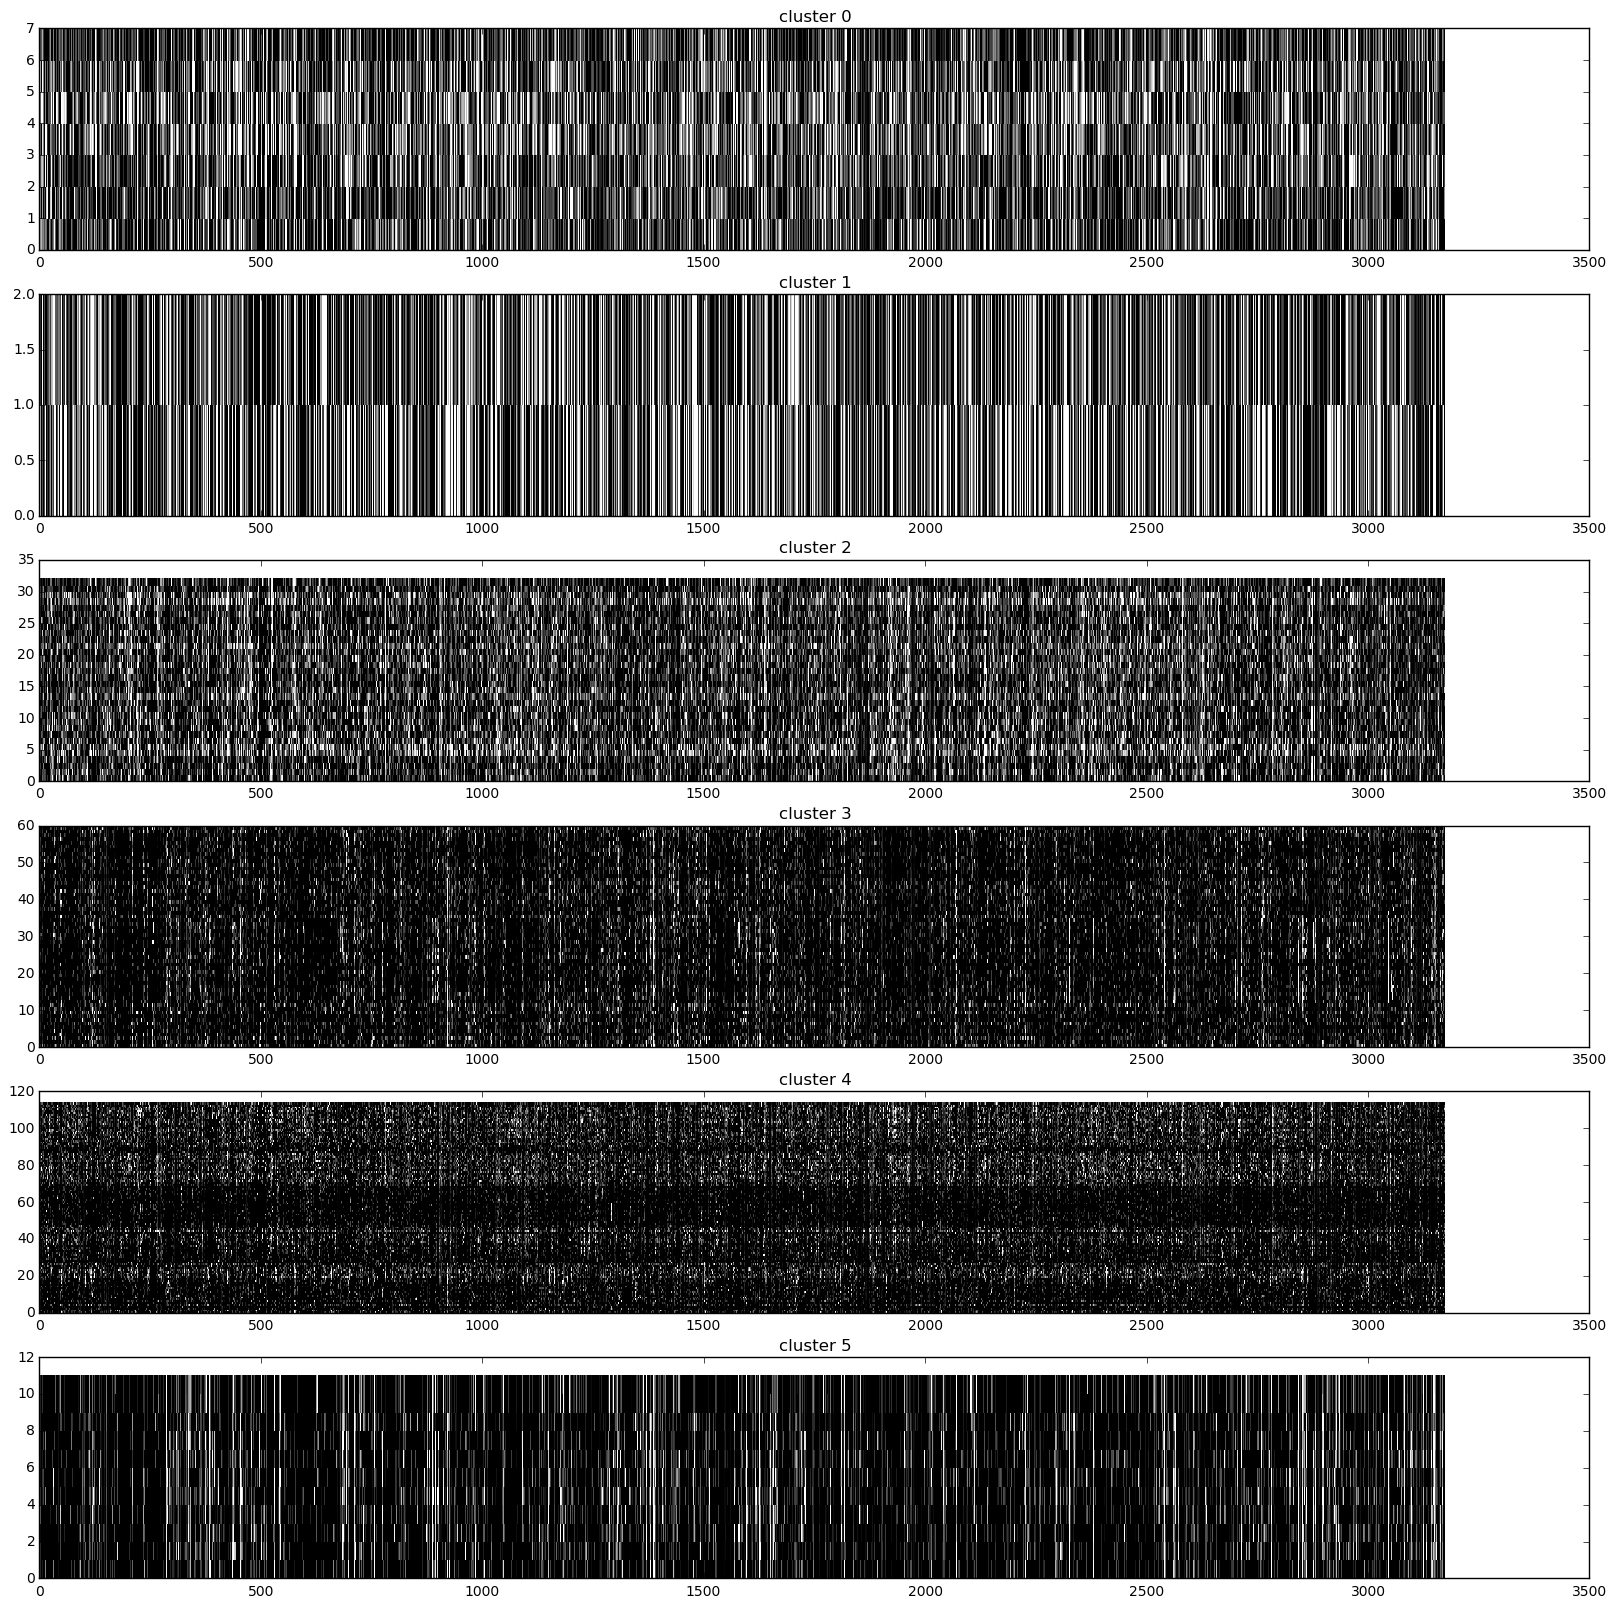

In [12]:
#plot clustered speeches

%matplotlib inline
from matplotlib import pyplot as plt 

uni_plt = np.unique(sort_clust)
plt.figure(figsize=(20,20))
for p in uni_plt:
    plt.subplot(len(uni_plt),1,p+1)
    this_clust = (sort_clust == p)
    plt.pcolor(sort_tfidf[this_clust],cmap='gray',vmax=5,vmin=0)
    plt.title('cluster %d' %(p))
    